In [1]:

import torch
import numpy as np
%load_ext autoreload
%autoreload 2
from utils1 import load_data,default_loader,trainset,imshow,normal,layershow
from torch.utils.data import Dataset, DataLoader
import torchvision
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt
from torchsummary import summary

**Data Path**

In [2]:
datapath = "/home/tete/data/Youtube"
data,paths,labels = load_data(datapath)
available_field = ['url','videoname','locs','frameids','label_names','crop','scale','origRes','isYouTubeSubset']


**shift the data**

In [3]:
num_data=len(paths)
index=np.arange(num_data)
np.random.shuffle(index)
paths=[paths[i] for i in index]
labels=[labels[i] for i in index]

**partition of the data into three part**

In [4]:
#how many data we will put into each set
train_num,val_num, test_num  = int(0.50*num_data),int(num_data*0.30),int(num_data*0.2)

assert(train_num+val_num+test_num<=num_data)
train_path,train_label=paths[0:train_num],labels[0:train_num]
val_path,  val_label  =paths[train_num:train_num+val_num],labels[train_num:train_num+val_num]
test_path, test_label =paths[train_num+val_num:],labels[train_num+val_num:]

train_data  = trainset(train_path,train_label)
trainloader = DataLoader(train_data, batch_size=4,shuffle=True)

val_data  = trainset(val_path,val_label)
valloader = DataLoader(val_data, batch_size=4,shuffle=True)

test_data  = trainset(test_path,test_label)
testloader = DataLoader(test_data, batch_size=4,shuffle=True)
print("number of data in the training set    :", len(train_data))
print("number of data in the validation set  :", len(val_data))
print("number of data in the test set        :", len(test_data))

number of data in the training set    : 2500
number of data in the validation set  : 1500
number of data in the test set        : 1000


**load example data from test set**

In [5]:
count = 1
for data in testloader:
    if count == 1:
        inputs_try,labels_try = data
    count +=1
print(count,"batches")   
print(inputs_try.shape)
print(labels_try.shape)

251 batches
torch.Size([4, 3, 180, 320])
torch.Size([4, 7, 2])


In [6]:
torch.tensor(np.random.uniform(size=[10,5]),dtype=torch.float32)

tensor([[0.3001, 0.0331, 0.7483, 0.0239, 0.3236],
        [0.8175, 0.1230, 0.3457, 0.3081, 0.7070],
        [0.1905, 0.5607, 0.6771, 0.3923, 0.5048],
        [0.4309, 0.9340, 0.9344, 0.4426, 0.5037],
        [0.3050, 0.7273, 0.2061, 0.2905, 0.9149],
        [0.2936, 0.9732, 0.8388, 0.1083, 0.9211],
        [0.6663, 0.1422, 0.8960, 0.6887, 0.6029],
        [0.7513, 0.9198, 0.4404, 0.7839, 0.2613],
        [0.5372, 0.2564, 0.5334, 0.3984, 0.5413],
        [0.9175, 0.4049, 0.7310, 0.1853, 0.4251]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


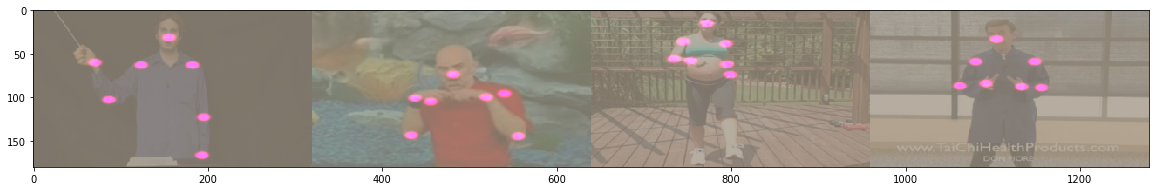

In [7]:
out = torchvision.utils.make_grid(inputs_try,padding=0)
imshow(out,labels_try) 

In [8]:
use_gpu=torch.cuda.is_available()
use_gpu

True

In [13]:
model=torchvision.models.resnet152(pretrained=True)
model=model.to("cuda")

In [19]:
print(summary(model,(3,256,256)))

RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 11.17 GiB total capacity; 9.95 GiB already allocated; 960.00 KiB free; 8.54 MiB cached)

In [15]:

def train(model,data_loader,loss_fn,optimizer,n_epochs=10):
    if use_gpu:
        model=model.to("cuda")
        
    model.train(True)
    
    loss_train = np.zeros(n_epochs)
    acc_train = np.zeros(n_epochs)
    optimizer = optimizer
    
    for epoch_num in range(n_epochs):
        running_corrects = 0.0
        running_loss = 0.0
        size = 0
        for data in data_loader:
            inputs, labels = data
            bs = labels.size(0)
            
            if use_gpu:
                inputs=inputs.cuda()
                labels=labels.cuda()
            
            
            outputs = model(inputs)
            #print(outputs.shape, labels.shape)
            loss = loss_fn(outputs,labels) 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #running_loss+=loss.data.item()
            #_,preds = torch.max(outputs.data,1)
            preds=outputs.data
            # statistics
            running_loss += loss.data.item()
            #print(preds.shape,labels.shape)
            #running_corrects += torch.sum(preds == labels)
            
            if(size%int(len(data_loader)/3)==0 and size!=0):
                print(running_loss / size, size)
            size += bs
              
            
        epoch_loss = running_loss / size
        #epoch_acc = running_corrects.item() / size
        loss_train[epoch_num] = epoch_loss
        #acc_train[epoch_num] = epoch_acc
        print('Epoch: ',epoch_num,'Train - Loss: {:.4f}'.format(epoch_loss))
        
    return loss_train#, acc_train


In [16]:
pose_detection = Regressor()
# choose the appropriate loss
loss_fn = nn.MSELoss(reduction='sum')
#loss_fn = nn.MSELoss(reduction='sum')
learning_rate = 1.0
# your SGD optimizer
#optimizer_cl = torch.optim.Adadelta(pose_detection.parameters(),lr = learning_rate)
optimizer_cl = torch.optim.Adadelta(pose_detection.parameters(),lr = learning_rate)
# and train for 10 epochs
l_t=[]

In [ ]:
l_t.extend(train(pose_detection,trainloader,loss_fn,optimizer_cl,n_epochs = 5))

57390.66759314904 208
39759.79414250301 416
33901.54481545473 624
29944.877178485578 832
27823.476434795673 1040
26410.54826472356 1248
25179.412480951665 1456
24131.871864905723 1664
23254.64743798411 1872
22764.614817457932 2080
22292.422238650022 2288
21912.223851913062 2496
Epoch:  0 Train - Loss: 21877.1643
15493.585298978365 208
16324.289954552283 416
16417.882430639023 624
16391.03857891376 832
16445.624248798078 1040
16420.010286771336 1248
16448.588610973988 1456
16414.25153996394 1664
16404.595088600094 1872
16337.771895658052 2080
16336.244980605332 2288
16315.274302947215 2496
Epoch:  1 Train - Loss: 16289.1699
16069.976825420674 208
15418.996610201322 416
15757.96610201322 624
15754.775493915264 832
15642.230421799879 1040
15685.686415452223 1248
15600.587537828382 1456
15637.73866037222 1664
15529.453111436633 1872
15493.731439678486 2080
15552.335440682364 2288
15460.55888640575 2496
Epoch:  2 Train - Loss: 15435.8220
15499.09305513822 208
14899.411865234375 416
15120.42

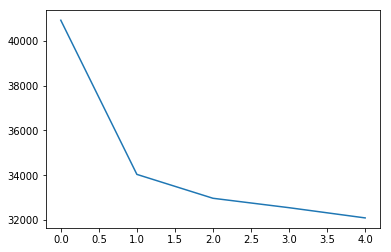

In [62]:
plt.plot(range(len(l_t)),l_t)

In [63]:
def test(model,loss_fn,optimizer,data_loader):
    model.train(False)
    if use_gpu:
        model=model.to("cuda")
    running_corrects = 0.0
    running_loss = 0.0
    size = 0

    for data in data_loader:
        inputs, labels = data    
        bs = labels.size(0)
        
        if use_gpu:
            inputs=inputs.cuda()
            labels=labels.cuda()
        
        outputs = model(inputs)
        loss = loss_fn(outputs,labels) 

        #running_loss+=loss.data.item()
        #_,preds = torch.max(outputs.data,1)
        # statistics
        running_loss += loss.data.item()
        #running_corrects += torch.sum(preds == labels)
        size += bs
    epoch_loss = running_loss / size
        #epoch_acc = running_corrects.item() / size
    loss_train[epoch_num] = epoch_loss
        #acc_train[epoch_num] = epoch_acc
    print('Test - Loss: {:.4f}'.format(epoch_loss))
    


In [71]:
pose_detection.train(False)    
preds = pose_detection(inputs_try.cuda()).cpu()
print(preds.shape)
print(labels_try.shape)

torch.Size([4, 7, 2])
torch.Size([4, 7, 2])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


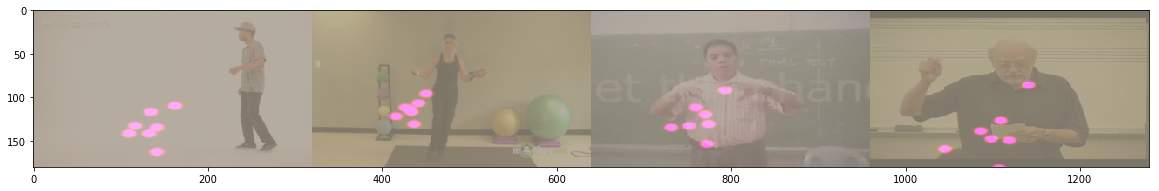

In [72]:
out = torchvision.utils.make_grid(inputs_try,padding=0)
imshow(out,preds) 